# COGNITION AND COMPUTATION 2024-2025
## Final Project: Exploring Computational Models of Visual Concept Learning

**Name:** Angelo Guarino

**Student ID:** 2130763

**Date of Submission:** 06/07/2025

---

Building upon the principles and techniques discussed during the course, this work investigates how hierarchical neural network models, specifically Deep Belief Networks (DBNs), with a comparison to Feedforward Neural Networks (FFNNs), learn to represent and classify visual information from the Fashion-MNIST dataset.

PS. Exact metrics mentioned in the text cells may slightly vary, as the notebook was run one last time before submission to ensure all outputs are reproducible.

In [ ]:
# Importing libraries and DBN scripts
def get_dbn_library():
  files = ["DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

In [ ]:
%%capture
get_dbn_library()

In [ ]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn.functional as functional
import torchvision as tv
import scipy.cluster as cluster
import sklearn.preprocessing
from sklearn.metrics import confusion_matrix
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from DBN import DBN

In [ ]:
# Setting computation device
print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {tv.__version__}")

if torch.cuda.is_available():
    print(f"CUDA is available. Using GPU: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda")
else:
    print("CUDA/MPS not available. Using CPU.")
    device = torch.device("cpu")

print(f"Selected device: {device}")

PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
CUDA is available. Using GPU: NVIDIA L4
Selected device: cuda


In [ ]:
# Download and load the training data
fashion_mnist_tr = datasets.FashionMNIST(
    root='data',  # directory where data will be stored
    train=True,
    download=True
)

# Download and load the test data
fashion_mnist_te = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True
)

# Scale pixel values to a [0,1] range
fashion_mnist_tr.data = fashion_mnist_tr.data / 255
fashion_mnist_te.data = fashion_mnist_te.data / 255

# Move data and targets to GPU
fashion_mnist_tr.data = fashion_mnist_tr.data.to(device)
fashion_mnist_te.data = fashion_mnist_te.data.to(device)
fashion_mnist_tr.targets = fashion_mnist_tr.targets.to(device)
fashion_mnist_te.targets = fashion_mnist_te.targets.to(device)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 177kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.22MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 20.4MB/s]


Training data shape: torch.Size([60000, 28, 28])
Training targets shape: torch.Size([60000])
Test data shape: torch.Size([10000, 28, 28])
Test targets shape: torch.Size([10000])
Data is on device: cuda:0

Fashion-MNIST Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


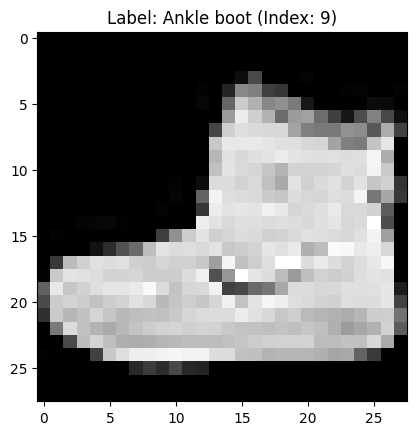

In [ ]:
print(f"Training data shape: {fashion_mnist_tr.data.shape}")
print(f"Training targets shape: {fashion_mnist_tr.targets.shape}")
print(f"Test data shape: {fashion_mnist_te.data.shape}")
print(f"Test targets shape: {fashion_mnist_te.targets.shape}")
print(f"Data is on device: {fashion_mnist_tr.data.device}")

# Class names for Fashion-MNIST
class_names = fashion_mnist_tr.classes
print(f"\nFashion-MNIST Classes: {class_names}")

# Visualize a sample image
plt.imshow(fashion_mnist_tr.data[0].cpu().numpy(), cmap='gray')
# Get the numerical label
label_index = fashion_mnist_tr.targets[0].item()
# Get the class name using the label_index
class_name = class_names[label_index]

plt.title(f"Label: {class_name} (Index: {label_index})")
plt.show()

# DBN and FFNN: Implementation, Training, and Tuning

### DBN Hyperparameter Tuning Results

**Baseline Configuration:**
* visible_units: 784 (from 28\*28 images)
* hidden_units: [500, 500, 1000]
* k (CD-k steps): 1
* learning_rate: 0.05
* learning_rate_decay: False
* initial_momentum: 0.5
* final_momentum: 0.9
* weight_decay: 0.0001
* xavier_init: False
* increase_to_cd_k: False
* num_epochs_dbn (per RBM layer): 50
* batch_size_dbn: 100

| Run | Avg. Rec. Err. (Final RBM Layer) | Key Change from Baseline Settings       |
|-----|------------------------------------|-----------------------------------------|
| 1   | 0.6934                             | (Matches Baseline Configuration)        |
| 2   | 0.6896                             | `num_epochs_dbn = 100`                  |
| 3   | 1.0012                             | `k = 2`                                 |
| 4   | 0.6446                             | `learning_rate = 0.1`                   |
| 5   | 0.6423                             | `xavier_init = True`                    |
| 6   | 0.3692                             | `hidden_units = [1000, 1000, 1500]`     |

I also tested other runs playing with the hidden units size. I tried to use less neurons per layer:
 * hidden_units = [400, 500, 800]
 * hidden_units = [250, 500, 750]

Additionally, I tried to stack more RBMs, and I tested both increasing and decreasing sizes of the layers:
 * hidden_units = [250, 250, 500, 500, 1000]
 * hidden_units = [1000, 500, 500, 250, 250]
 * hidden_units = [250 500, 500, 750]
 * hidden_units = [200, 400, 600, 800]
 * hidden_units = [800, 600, 400, 200]

The following configuration was able to achieve the highest linear read-out accuracies.

In [ ]:
# Deep Belief Network (DBN) - Definition and Training
dbn_fashion = DBN(
    visible_units=28*28,
    hidden_units=[500, 500, 1000],
    k=1,
    learning_rate=0.1,
    learning_rate_decay=False,
    initial_momentum=0.5,
    final_momentum=0.9,
    weight_decay=0.0001,
    xavier_init=True,
    increase_to_cd_k=False,
    use_gpu=torch.cuda.is_available()
)

num_epochs_dbn = 50
batch_size_dbn = 100

print("Starting DBN training...")
# The DBN's train_static method expects the data to be flat for visible_units
dbn_fashion.train_static(
    fashion_mnist_tr.data.reshape(-1, 28*28), # Flatten the images
    fashion_mnist_tr.targets,
    num_epochs_dbn,
    batch_size_dbn
)
print("DBN training completed.")

Starting DBN training...
--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.4888     |0.0722       |340.6808   |8.0011     |
|20    |1.3486     |0.0669       |307.5375   |6.2639     |
|30    |1.3083     |0.0656       |298.6342   |5.8524     |
|40    |1.2893     |0.0649       |293.8279   |5.6934     |
|50    |1.2812     |0.0658       |293.1266   |6.1588     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.8409     |0.0311       |159.7366   |3.5466     |
|20    |0.7807     |0.0272       |151.8259   |2.7935     |
|30    |0.7646     |0.0275       |148.6378   |3.0677     |
|40    |0.7555     |0.0254       |147.3927   |2.8265     |
|50    |0.7499     |0.0266       |145.5708   |2.6415     |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.7558     |0.0272       |174.1057   |3.4807     |
|20    |0.6833     |0.0254

### FFNN: Architecture and Hyperparameter Configuration

First run: using three hidden layers with the same sizes as the DBN, ReLU (which helps with vanishing gradients), lr=0.05, epochs=1000. The test accuracy was: 0.8193.


To keep it comparable to the final DBN, the only change I made was to the learning rate, from 0.05 to 0.1 - same as the DBN. The final test accuracy improved: 0.8404.

In [ ]:
# -----------------------------------------------------------------------------
# Feed-Forward Neural Network (FFNN) - Definition and Training
# -----------------------------------------------------------------------------
class Feedforward(torch.nn.Module):
  def __init__(self, first_hidden_layer_size, second_hidden_layer_size, third_hidden_layer_size):
    super().__init__()
    self.first_hidden = torch.nn.Linear(784, first_hidden_layer_size)
    self.second_hidden = torch.nn.Linear(first_hidden_layer_size, second_hidden_layer_size)
    self.third_hidden = torch.nn.Linear(second_hidden_layer_size, third_hidden_layer_size)
    self.output = torch.nn.Linear(third_hidden_layer_size, 10)

  def forward(self, input):
    relu = torch.nn.ReLU()
    first_hidden_repr = relu(self.first_hidden(input))
    second_hidden_repr = relu(self.second_hidden(first_hidden_repr))
    third_hidden_repr = relu(self.third_hidden(second_hidden_repr))
    output = self.output(third_hidden_repr)
    return output

In [ ]:
def train_supervised(network, input_data, epochs=1000):
  optimizer = torch.optim.SGD(network.parameters(), lr=0.1)
  loss_fn = torch.nn.CrossEntropyLoss()

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = network(input_data).squeeze()
    targets = fashion_mnist_tr.targets.reshape(predictions.shape[0])
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch + 1, epochs, loss))

In [ ]:
def compute_accuracy(predictions_test, targets):
  predictions_indices = predictions_test.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

In [ ]:
ffnn = Feedforward(500, 500, 1000).to(device)

In [ ]:
train_supervised(ffnn, fashion_mnist_tr.data.reshape((60000, 784)), 1000)

epoch :   1/1000, loss = 2.3036
epoch : 101/1000, loss = 0.9155
epoch : 201/1000, loss = 0.6908
epoch : 301/1000, loss = 0.5860
epoch : 401/1000, loss = 0.5345
epoch : 501/1000, loss = 0.5111
epoch : 601/1000, loss = 0.4672
epoch : 701/1000, loss = 0.4615
epoch : 801/1000, loss = 0.4387
epoch : 901/1000, loss = 0.4075


In [ ]:
predictions_ffnn = ffnn(fashion_mnist_te.data.reshape((10000, 784)))

In [ ]:
compute_accuracy(predictions_ffnn, fashion_mnist_te.targets)

0.840499997138977

# Linear Read-outs and Representation Disentanglement in DBN Layers

Even though Fashion-MNIST is more complex than MNIST, it still consists of simple, centered, grayscale images.

It's plausible that the first hidden layer H1 is extracting the most critical features effectively, while H2 and H3 are refining these features, learning more abstract combinations - as shown by the decreasing reconstruction errors.

However, these refinements may not significantly improve the linear separability of the classes, which is all that the linear readout can measure. In other words, it is possible that H2 and H3 are learning more complex, non-linear relationships that are valuable but cannot be effectively utilized by a simple linear classifier.

The higher learning rate on the linear classifiers (using the same model's configuration) led to a sligthly higher accuracy.

| Run Configuration                           | H1 Accuracy | H2 Accuracy | H3 Accuracy |
|---------------------------------------------|-------------|-------------|-------------|
| **Run 1** (Baseline)             | 82.97%      | 82.86%      | 83.16%      |
| **Run 5** (Linear Classifiers lr=0.05)  | 83.05%      | 83.26%      | 83.29%      |
| **Run 5** (Linear Classifiers lr=0.1) | 84.44%      | 84.53%      | 84.39%      |




In [ ]:
class LinearModel(torch.nn.Module):
    def __init__(self, layer_size, num_classes=10):
        super().__init__()
        self.linear = torch.nn.Linear(layer_size, num_classes)

    def forward(self, x):
        return self.linear(x)

In [ ]:
def get_kth_layer_repr(input, k, device):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  hidden_repr, __ = dbn_fashion.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr

In [ ]:
hidden_repr_1 = get_kth_layer_repr(fashion_mnist_tr.data, 0, device)
hidden_repr_2 = get_kth_layer_repr(hidden_repr_1, 1, device)
hidden_repr_3 = get_kth_layer_repr(hidden_repr_2, 2, device)

In [ ]:
layer_size = dbn_fashion.rbm_layers[0].W.shape[1]
linear1 = LinearModel(layer_size).to(device)

layer_size = dbn_fashion.rbm_layers[1].W.shape[1]
linear2 = LinearModel(layer_size).to(device)

layer_size = dbn_fashion.rbm_layers[2].W.shape[1]
linear3 = LinearModel(layer_size).to(device)

In [ ]:
train_supervised(linear1, hidden_repr_1, 1000)
train_supervised(linear2, hidden_repr_2, 1000)
train_supervised(linear3, hidden_repr_3, 1000)

epoch :   1/1000, loss = 2.3070
epoch : 101/1000, loss = 0.6736
epoch : 201/1000, loss = 0.5667
epoch : 301/1000, loss = 0.5187
epoch : 401/1000, loss = 0.4894
epoch : 501/1000, loss = 0.4691
epoch : 601/1000, loss = 0.4540
epoch : 701/1000, loss = 0.4421
epoch : 801/1000, loss = 0.4324
epoch : 901/1000, loss = 0.4243
epoch :   1/1000, loss = 2.3506
epoch : 101/1000, loss = 0.6238
epoch : 201/1000, loss = 0.5360
epoch : 301/1000, loss = 0.4959
epoch : 401/1000, loss = 0.4716
epoch : 501/1000, loss = 0.4548
epoch : 601/1000, loss = 0.4423
epoch : 701/1000, loss = 0.4326
epoch : 801/1000, loss = 0.4247
epoch : 901/1000, loss = 0.4181
epoch :   1/1000, loss = 2.2941
epoch : 101/1000, loss = 0.6377
epoch : 201/1000, loss = 0.5408
epoch : 301/1000, loss = 0.4981
epoch : 401/1000, loss = 0.4726
epoch : 501/1000, loss = 0.4551
epoch : 601/1000, loss = 0.4421
epoch : 701/1000, loss = 0.4320
epoch : 801/1000, loss = 0.4238
epoch : 901/1000, loss = 0.4170


In [ ]:
hidden_repr_1_test = get_kth_layer_repr(fashion_mnist_te.data, 0, device)
hidden_repr_2_test = get_kth_layer_repr(hidden_repr_1_test, 1, device)
hidden_repr_3_test = get_kth_layer_repr(hidden_repr_2_test, 2, device)

In [ ]:
# compute the classifier predictions:
predictions_test1 = linear1(hidden_repr_1_test)
predictions_test2 = linear2(hidden_repr_2_test)
predictions_test3 = linear3(hidden_repr_3_test)

In [ ]:
print(compute_accuracy(predictions_test1, fashion_mnist_te.targets))
print(compute_accuracy(predictions_test2, fashion_mnist_te.targets))
print(compute_accuracy(predictions_test3, fashion_mnist_te.targets))

0.8441999554634094
0.8467999696731567
0.8459999561309814


# Analysis of Internal Model Representations

## Receptive Fields Visualization

The DBN is overall able to progress from simple edge detectors in the first hidden layer (H1) to more complex feature combinations in H2, and finally to clearer, "prototype-like" representations of whole object categories in the deepest layer (H3).

It is to be noted that some representations in the first hidden layer are already "prototype-like".

Run 1 and the current run produce similar receptive fields visualizations. The bigger model instead, produces "noisy" or completely black visualizations. When trying to tune the threshold to improve the visualization, is it possible to see how many fields look identical. This is probably due to overfitting, where multiple neurons converge on learning the same or very similar features.

In [ ]:
def get_weights(dbn, layer):
  return dbn.rbm_layers[layer].W.cpu().numpy()

def apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold)

def apply_min_max_scaler(learned_weights):
  original_shape = learned_weights.shape
  min_max_scaler = sklearn.preprocessing.MinMaxScaler()
  min_max_scaled_learned_weights = min_max_scaler.fit_transform(learned_weights.ravel().reshape(-1,1))
  min_max_scaled_learned_weights = min_max_scaled_learned_weights.reshape(original_shape)
  return min_max_scaled_learned_weights

def plot_layer_receptive_fields(weights):
  num_subplots = 100
  n_rows_cols = int(math.sqrt(num_subplots))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[i,:].reshape((28,28)), cmap=plt.cm.gray)  # here we select the weights we want to plot

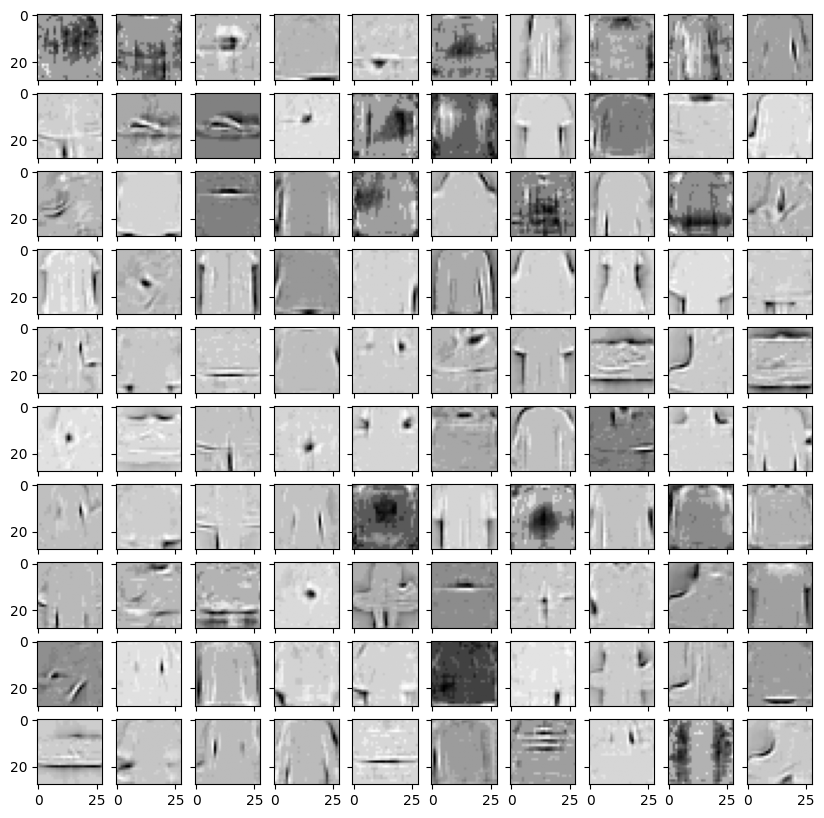

In [ ]:
w1 = get_weights(dbn_fashion, layer=0)
w1 = apply_threshold(w1, 0.1)
w1 = apply_min_max_scaler(w1)

plot_layer_receptive_fields(w1.T)

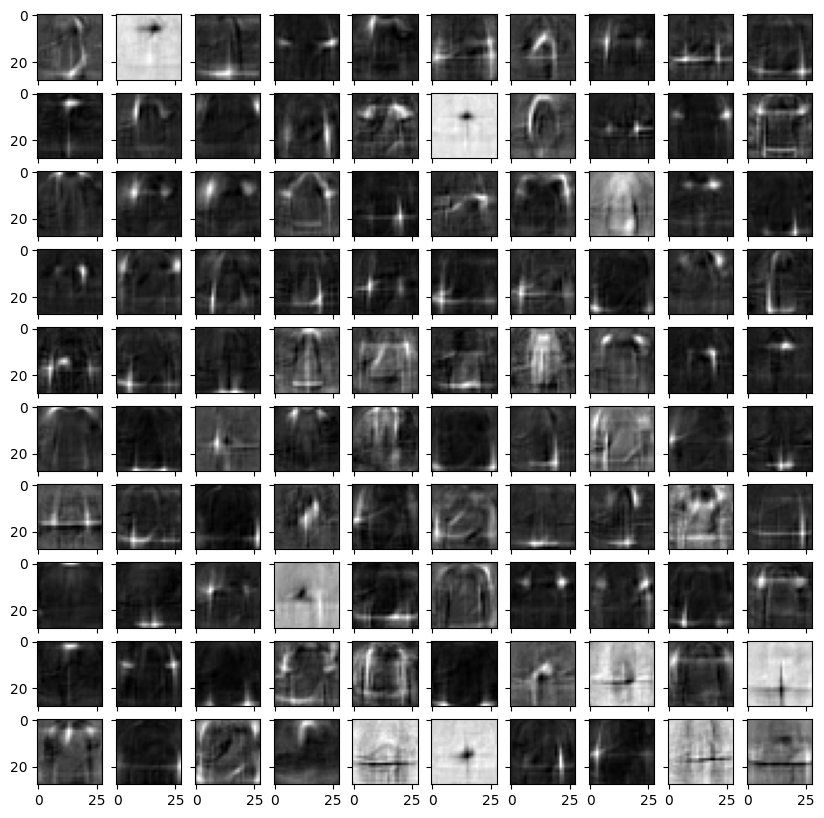

In [ ]:
w1 = get_weights(dbn_fashion, layer=0)
w2 = get_weights(dbn_fashion, layer=1)

w1 = apply_threshold(w1, 0.1)
w2 = apply_threshold(w2, 0.1)

w_product = (w1 @ w2)  # here we do the projection
w_product = apply_threshold(w_product, 0.1)
w_product = apply_min_max_scaler(w_product)

plot_layer_receptive_fields(w_product.T)

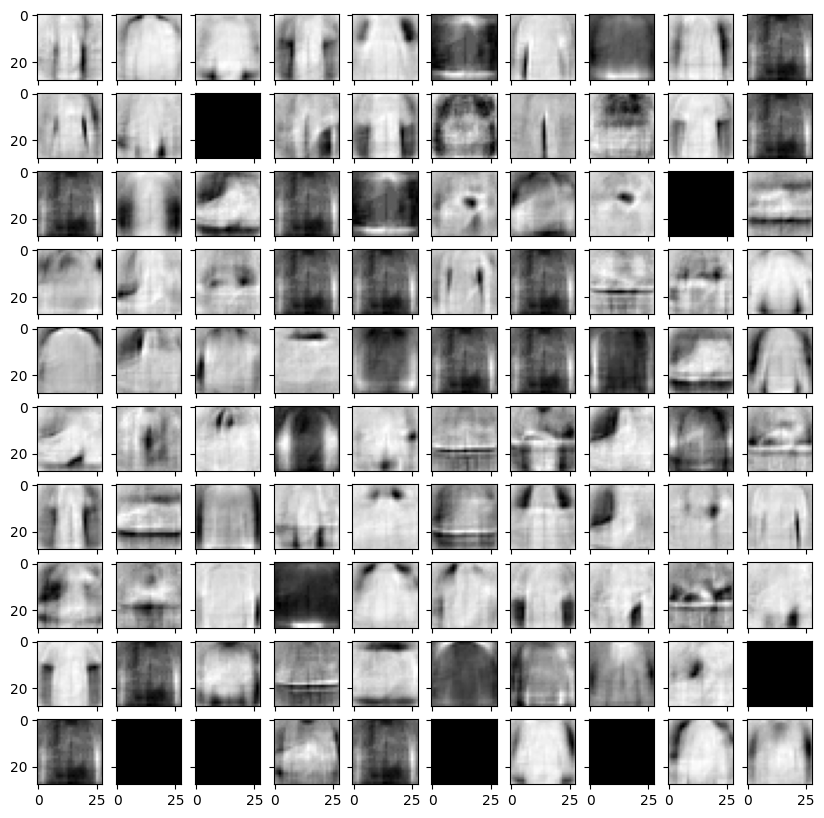

In [ ]:
w1 = get_weights(dbn_fashion, layer=0)
w2 = get_weights(dbn_fashion, layer=1)
w3 = get_weights(dbn_fashion, layer=2)

w1 = apply_threshold(w1, 0.1)
w2 = apply_threshold(w2, 0.1)
w3 = apply_threshold(w3, 0.1)

w_product_12 = (w1 @ w2)  # here we do the projection
w_product_23 = (w_product_12 @ w3)  # here we do the projection
w_product_23 = apply_threshold(w_product_23, 0.1)
w_product_23 = apply_min_max_scaler(w_product_23)

plot_layer_receptive_fields(w_product_23.T)

**Run 1: first receptive field**

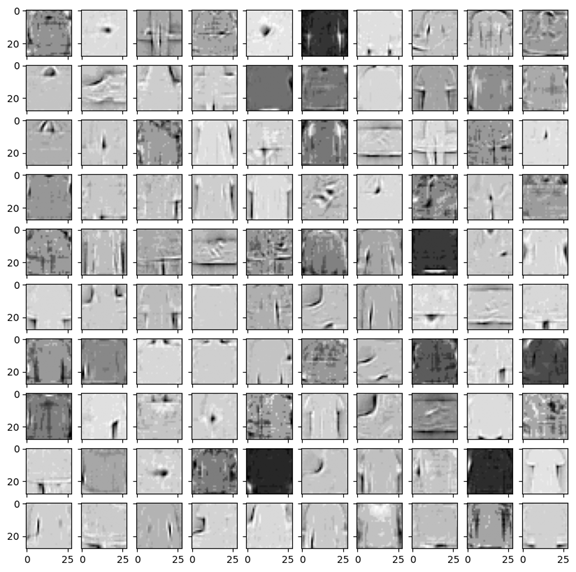

**Run 1: second receptive field**

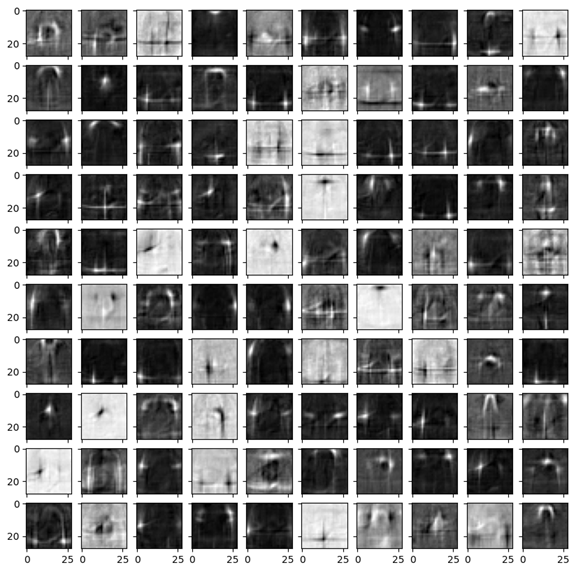

**Run 1: third receptive field**

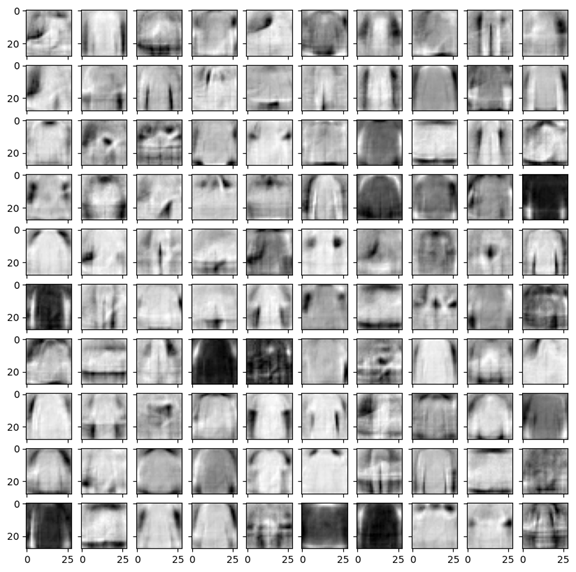

**Run 6 ('bigger' model): third receptive field at threshold 0.1**

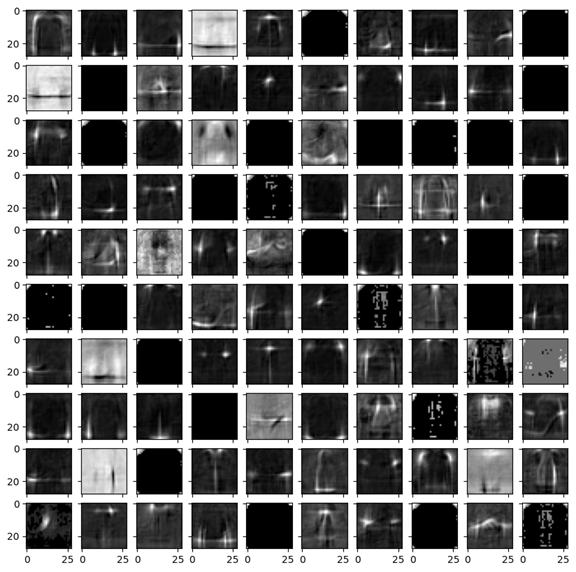

**Run 6 ('bigger' model): third receptive field at threshold 0**

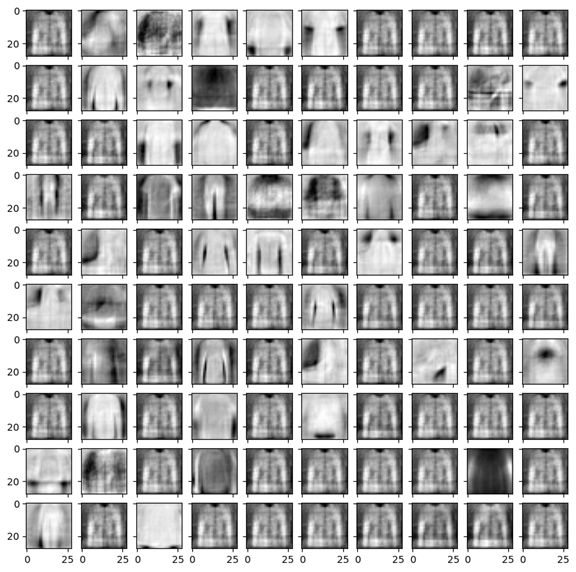

## Internal Representations Clustering

It was difficult to assess which model performed better at clustering, as the main difference in every case was the placement of the 'Bag' class. In the first run, the 'Bag' class was placed together with footwear, while in the subsequent runs it was grouped with top-wear elements. Looking at the images, it is easy to see why this might occur, as the 'squared' shape of bags is similar to the silhouette of tops and also to the form of some footwear, especially ankle boots.

Notably, every model clustered 'Dress' and 'Trousers' together, suggesting that the models found similarities in the general shapes and overall figures of these two classes.

In all cases, though, it is plausible to conclude that the DBN developed an overall meaningful hierarchical understanding of the categories based on visual features.

For this notebook, I also decided to visualize the clustering per each hidden layer of the current run. The main difference between layers is the placement of the "T-shirt/top" class, which gets placed with 'Trouser' and 'Dress' in the second layer, and with 'Bag', 'Coat', 'Pullover' and 'Shirt' in the other two. The dissimilarity between clusters remains overall the same.

In [ ]:
def get_kth_layer_repr(input, k, device):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  hidden_repr, __ = dbn_fashion.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr

In [ ]:
hidden_repr_1 = get_kth_layer_repr(fashion_mnist_tr.data, 0, device)
hidden_repr_2 = get_kth_layer_repr(hidden_repr_1, 1, device)
hidden_repr_3 = get_kth_layer_repr(hidden_repr_2, 2, device)
print(hidden_repr_1.shape)
print(hidden_repr_2.shape)
print(hidden_repr_3.shape)

torch.Size([60000, 500])
torch.Size([60000, 500])
torch.Size([60000, 1000])


In [ ]:
def get_mask(label):  # we use this function to filter by class
  labels = fashion_mnist_tr.targets.cpu().numpy()
  return labels == label

def get_label_to_mean_hidd_repr(hidden_repr):
  hidden_repr_np = hidden_repr.cpu().numpy()
  return {
    label: hidden_repr_np[get_mask(label)].mean(axis=0)  # here we filter by class and compute the mean
    for label in range(10)
  }

def get_hidden_reprs_matrix(hidden_repr):  # we use this to build the matrices
  label_to_mean_hidd_repr = get_label_to_mean_hidd_repr(hidden_repr)
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)  # here we adjust the shape of centroids to do the concat
    for label in range(10)])

In [ ]:
mean_hidd_repr_matrix_1 = get_hidden_reprs_matrix(hidden_repr_1)
mean_hidd_repr_matrix_2 = get_hidden_reprs_matrix(hidden_repr_2)
mean_hidd_repr_matrix_3 = get_hidden_reprs_matrix(hidden_repr_3)

In [ ]:
def plot_dendrogram(mean_repr_matrix, custom_labels, title=""):
  fig, ax = plt.subplots(figsize=(10, 5)) # Increased figure size for better label display
  linkage_matrix = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")

  dendrogram = cluster.hierarchy.dendrogram(
      linkage_matrix,
      labels=custom_labels,      # Use the custom labels here
      leaf_rotation=0,           # Rotate labels to be vertical for readability
      leaf_font_size=10          # Adjust font size as needed
  )

  ax.set_title(title, fontsize=15)
  plt.ylabel("Distance (Dissimilarity)", fontsize=12)
  plt.xticks(fontsize=10)
  plt.yticks(fontsize=10)
  plt.tight_layout() # Adjusts plot to ensure everything fits without overlapping
  plt.show()

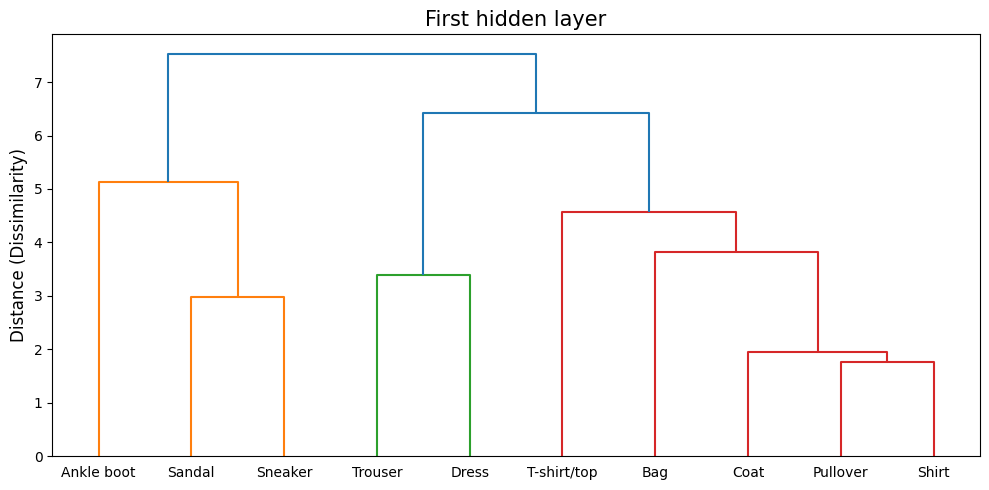

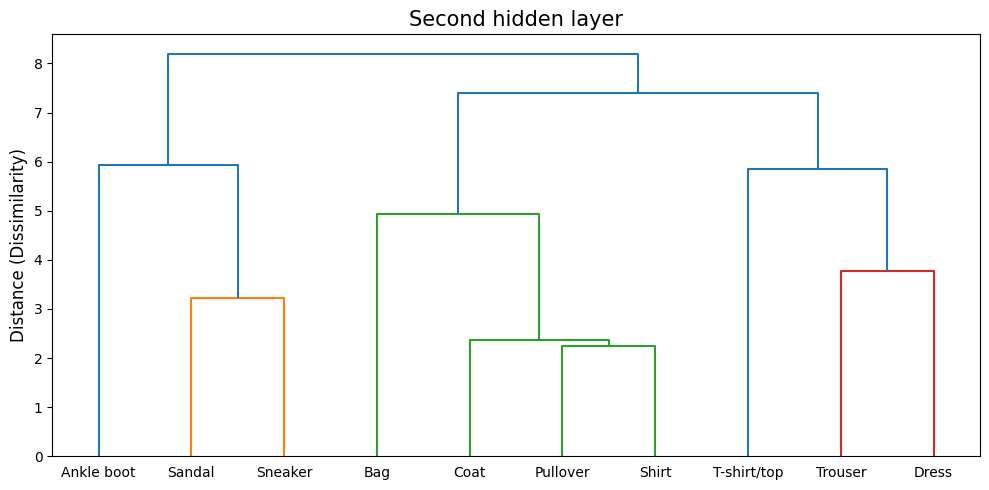

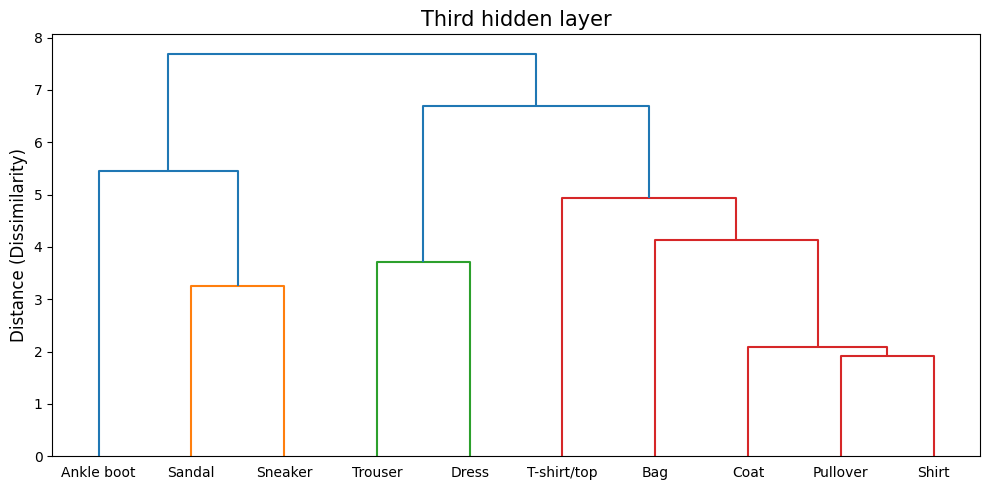

In [ ]:
class_names = fashion_mnist_tr.classes
plot_dendrogram(mean_hidd_repr_matrix_1, class_names, "First hidden layer")
plot_dendrogram(mean_hidd_repr_matrix_2, class_names, "Second hidden layer")
plot_dendrogram(mean_hidd_repr_matrix_3, class_names, "Third hidden layer")

# Error Analysis

## Confusion Matrices

From the confusion matrices we can see how both the DBN and the FFNN models are prone to the same type of errors.

There is also a relation between the type of errors and the previous hierarchical clustering. The errors are more common between classes that were clustered together. It does make sense, as those classes share some similarities, and instances might be confused.

In [ ]:
# Function to Plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred_indices, class_names_list, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function computes, prints, and plots the confusion matrix.

    Args:
        y_true (torch.Tensor or np.array): True labels.
        y_pred_indices (torch.Tensor or np.array): Predicted class indices from the model.
        class_names_list (list): List of class names for axis labels.
        title (str): Title for the plot.
        cmap (matplotlib.colors.Colormap): Colormap for the heatmap.
    """
    # Ensure labels are on CPU and are numpy arrays
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.cpu().numpy()
    if isinstance(y_pred_indices, torch.Tensor):
        y_pred_indices = y_pred_indices.cpu().numpy()

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred_indices)

    plt.figure(figsize=(8, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                xticklabels=class_names_list, yticklabels=class_names_list,
                annot_kws={"size": 10}) # Adjust annotation font size if needed
    plt.title(title, fontsize=15)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()


Plotting Confusion Matrix for DBN (H3 Readout) on Fashion-MNIST...


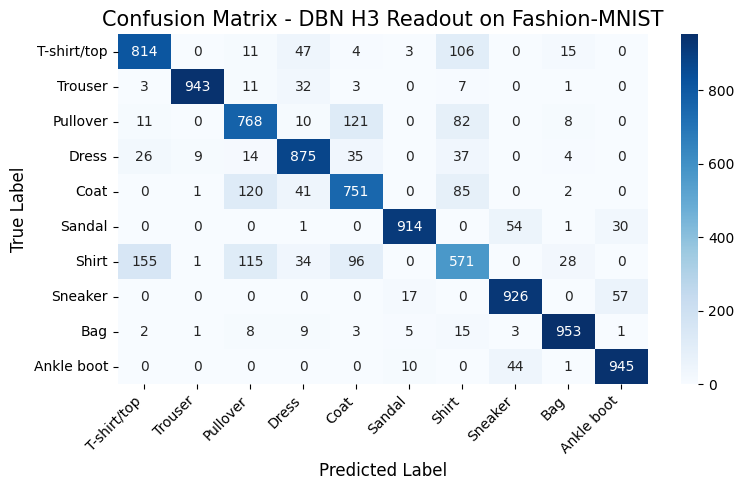

In [ ]:
dbn_h3_pred_indices = predictions_test3.max(axis=1).indices

# True labels for the test set (same as for FFNN)
true_labels_te = fashion_mnist_te.targets

# Plot the confusion matrix
print("\nPlotting Confusion Matrix for DBN (H3 Readout) on Fashion-MNIST...")
plot_confusion_matrix(true_labels_te,
                      dbn_h3_pred_indices,
                      class_names_list=class_names,
                      title='Confusion Matrix - DBN H3 Readout on Fashion-MNIST')

Plotting Confusion Matrix for FFNN...


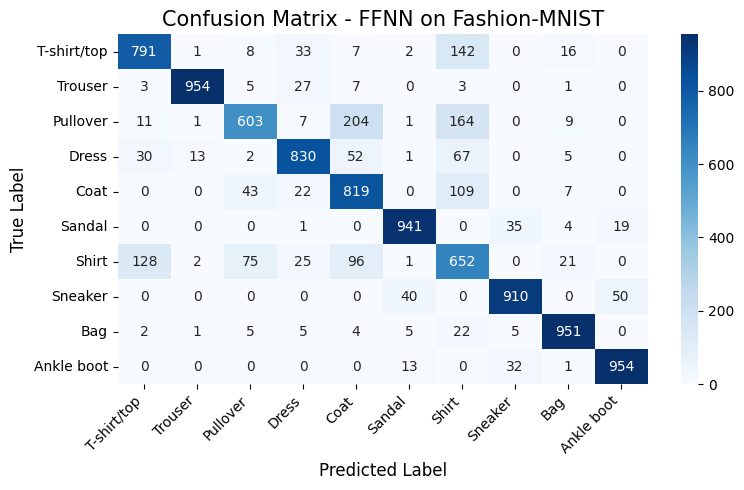

In [ ]:
# Confusion Matrix for FFNN

# Get predicted class indices for FFNN
# predictions_ffnn are raw scores/logits, so we need to get the argmax
ffnn_pred_indices = predictions_ffnn.max(axis=1).indices

# True labels for the test set
true_labels_te = fashion_mnist_te.targets

# Plot the confusion matrix
print("Plotting Confusion Matrix for FFNN...")
plot_confusion_matrix(true_labels_te,
                      ffnn_pred_indices,
                      class_names_list=class_names,
                      title='Confusion Matrix - FFNN on Fashion-MNIST')

## Psychometric Curves

Comparing pyschometric curves, we can see how all models show a decrease in accuracies as the noise level increases. For the DBN model, all three layers are more robust to random noise compared to the FFNN.

Moreover, while the first hidden layer is initially less accurate than deeper ones, its accuracy surpasses the third hidden layer's at the highest noise levels. This suggests that the simpler features learned by the first layer are more effective for classifying extremely noisy images.

This is the main difference from my previous notebook. From the psychometric curves, it looked like the FFNN was learning better. I could not understand why, as every other test proved that the DBN was effectively learning. The solution was removing the clamping of the noisy data in the inject_noise function. While both models accuracies deteriorated with clamping, the DBN was the most sensitive. Therefore it looked like the FFNN was learning better than the DBN.

In [ ]:
def inject_noise(mnist_data, noise_level):
  """
  Adds Gaussian noise to the input MNIST data.

  Args:
    mnist_data (torch.Tensor): The input image data.
    noise_level (float): The standard deviation of the Gaussian noise to add.
                         A value of 0 means no noise.

  Returns:
    torch.Tensor: The image data with added Gaussian noise.
  """
  # Generate Gaussian noise with the same shape as the input data
  # and the same device as the input data.
  noise = torch.randn_like(mnist_data) * noise_level
  noisy_data = mnist_data + noise

  return noisy_data

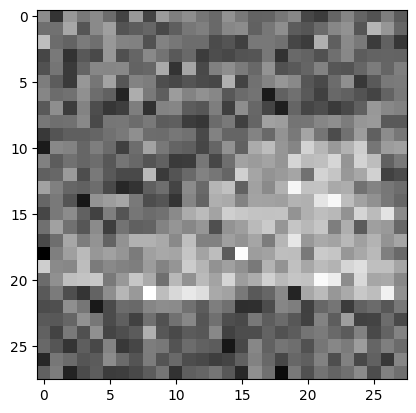

In [ ]:
noise_level = 0.3
mnist_test_with_noise = inject_noise(fashion_mnist_te.data, noise_level)
__ = plt.imshow(mnist_test_with_noise[0].reshape(28, 28).to("cpu"), cmap="gray")

In [ ]:
def get_accuracy_values_at_noise_level(noise_level):
  """
  Computes the classification accuracy for DBN read-outs and the FFNN
  on noisy MNIST test data.

  Args:
    noise_level (float): The level of Gaussian noise to inject into the test images.

  Returns:
    tuple: A tuple containing the accuracy of the first hidden layer read-out,
           second hidden layer read-out, third hidden layer read-out, and
           the feed-forward neural network.
  """
  mnist_test_with_noise = inject_noise(fashion_mnist_te.data, noise_level)  # create noisy test images

  # DBN representations and read-out accuracies
  hidden_repr_1_noisy = get_kth_layer_repr(mnist_test_with_noise, 0, device)  # here we compute the DBN representations
  hidden_repr_2_noisy = get_kth_layer_repr(hidden_repr_1_noisy, 1, device)
  hidden_repr_3_noisy = get_kth_layer_repr(hidden_repr_2_noisy, 2, device)

  predictions_first_hidden_noisy = linear1(hidden_repr_1_noisy)  # here we use the previously-trained read-out classifiers
  predictions_second_hidden_noisy = linear2(hidden_repr_2_noisy)
  predictions_third_hidden_noisy = linear3(hidden_repr_3_noisy)

  accuracy_first_hidden = compute_accuracy(predictions_first_hidden_noisy, fashion_mnist_te.targets)
  accuracy_second_hidden = compute_accuracy(predictions_second_hidden_noisy, fashion_mnist_te.targets)
  accuracy_third_hidden = compute_accuracy(predictions_third_hidden_noisy, fashion_mnist_te.targets)

  # Repeat a similar process for the feed-forward model
  noisy_test_data_reshaped_ffnn = mnist_test_with_noise.reshape((mnist_test_with_noise.shape[0], -1))

  # Get predictions from the FFNN using the noisy data
  predictions_ffnn_noisy = ffnn(noisy_test_data_reshaped_ffnn)

  # Compute accuracy for the FFNN
  accuracy_ffnn = compute_accuracy(predictions_ffnn_noisy, fashion_mnist_te.targets)

  return accuracy_first_hidden, accuracy_second_hidden, accuracy_third_hidden, accuracy_ffnn

In [ ]:
acc = get_accuracy_values_at_noise_level(0.3);
print("Accuracy of H1 read-out: %.3f" % acc[0])
print("Accuracy of H2 read-out: %.3f" % acc[1])
print("Accuracy of H3 read-out: %.3f" % acc[2])
print("Accuracy of FF network : %.3f" % acc[3])

Accuracy of H1 read-out: 0.814
Accuracy of H2 read-out: 0.826
Accuracy of H3 read-out: 0.831
Accuracy of FF network : 0.796


In [ ]:
def plot_noise_robustness_curves(noise_levels):
  accuracy_values_first_hidden = []
  accuracy_values_second_hidden = []
  accuracy_values_third_hidden = []
  accuracy_values_ffnn = []

  for noise_level in noise_levels:
    acc = get_accuracy_values_at_noise_level(noise_level)
    accuracy_values_first_hidden.append(acc[0])
    accuracy_values_second_hidden.append(acc[1])
    accuracy_values_third_hidden.append(acc[2])
    accuracy_values_ffnn.append(acc[3])

  fig, ax = plt.subplots()
  ax.plot(range(len(noise_levels)), accuracy_values_first_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_second_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_third_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_ffnn)

  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["First hidden", "Second hidden", "Third hidden", "FFNN"])

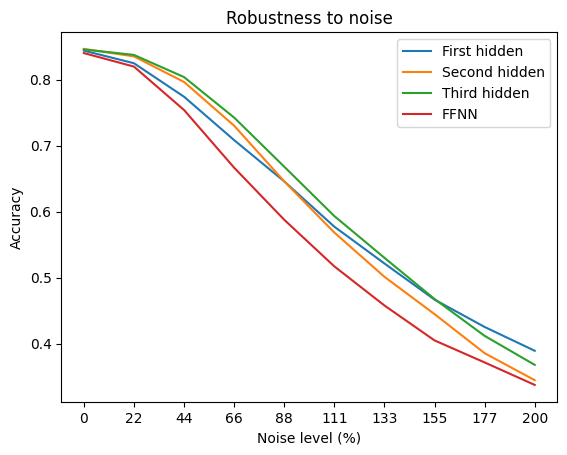

In [ ]:
noise_levels = np.linspace(0,2,10)
plot_noise_robustness_curves(noise_levels)

# Adversarial Attacks and Defenses

The DBN is also more robust to adversarial attacks, especially when the reconstruction defense is applied. The reconstruction process projects the adversarial image back onto the learned manifold of "valid" images, effectively "washing out" the structured adversarial noise before the final classification is made by the linear readout.

From the psychometric curves, we can see how the DBN with 2 top-down reconstruction steps performs on par with the baseline DBN. Increasing the number of reconstruction steps makes the model less accurate when the strength of the attack is low, but more robust to stronger attacks.


In [ ]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * sign_data_grad

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

In [ ]:
class DBNWithReadOut(torch.nn.Module):
    def __init__(self, dbn_mnist, readout):
        super().__init__()
        self.readout = readout
        self.readout_level = 2
        self.dbn_mnist = dbn_mnist
        self._require_grad()

    def _require_grad(self):
      for rbm in self.dbn_mnist.rbm_layers:
        rbm.W.requires_grad_()
        rbm.h_bias.requires_grad_()

    def forward(self, image):
      """This forward pass uses probabilities instead of samples as RBM activations
       to backpropagate the gradient"""
      p_v = image
      hidden_states = []
      for rbm in self.dbn_mnist.rbm_layers:
        p_v = p_v.view((p_v.shape[0], -1))  # flatten
        p_v, v = rbm(p_v)
        hidden_states.append(p_v)
      return self.readout.forward(hidden_states[self.readout_level])

dbn_with_readout = DBNWithReadOut(dbn_fashion, linear3)

In [ ]:
def test_robustness_to_attack(model, device, test_loader, epsilon, num_steps=0, verbose=True):
    correct = 0  # count number of correct classifications
    print_reconstruction = num_steps > 0  # if we request for top-down reconstruction, show the resulting image

    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.reshape(-1, 784)
        data.requires_grad = True  # we need to get the gradient to perform the attack

        output = model.forward(data)  # forward pass through the model

        init_pred = torch.argmax(output)  # prediction before the attack

        if (print_reconstruction and verbose):
          print("\nHere's the original sample:\n")
          plt.imshow(data[0].detach().to('cpu').numpy().reshape(28,28))
          plt.show()

        loss_value = torch.nn.functional.cross_entropy(output, target) # get loss value
        model.zero_grad()
        loss_value.backward()
        data_grad = data.grad.data  # collect the gradient with respect to the input data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)  # call the attack function previously defined

        if (print_reconstruction and verbose):
            print("\nHere's a perturbed sample:\n")
            plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
            plt.show()

        # If requested, reconstruct the input iterating bottom-up and top-down sampling
        if num_steps > 0:
            for __ in range(0, num_steps):
                perturbed_data, __ = model.dbn_mnist.reconstruct(perturbed_data)
            if (print_reconstruction and verbose):
                print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
                plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
                plt.show()
                print_reconstruction = False

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        # get the index of the max element in the output
        final_pred = output.max(1, keepdim=True)[1]
        final_pred = output.argmax(-1)
        correct += (final_pred == target).sum()

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader.sampler))
    print("\nEpsilon: {}\nTest Accuracy: {:.2f}%\n".format(epsilon, final_acc*100))

    return final_acc.item()

In [ ]:
test_loader = torch.utils.data.DataLoader(
    tv.datasets.FashionMNIST('data/', train=False, download=True, transform=tv.transforms.Compose([tv.transforms.ToTensor()])),
    batch_size=100, shuffle=True)

In [ ]:
final_acc = test_robustness_to_attack(ffnn, device,
                                      test_loader, epsilon=0.2,
                                      num_steps=0)

  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0.2
Test Accuracy: 0.19%



In [ ]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.2,
                                      num_steps=0)

  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0.2
Test Accuracy: 11.58%



### DBN with 2 top-down reconstruction steps

Testing DBN with 2 reconstruction steps against attack with epsilon = 0.2


  0%|          | 0/100 [00:00<?, ?it/s]


Here's the original sample:



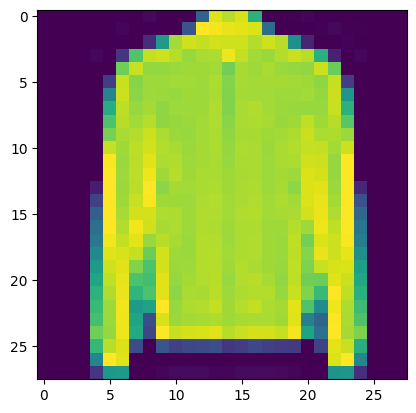


Here's a perturbed sample:



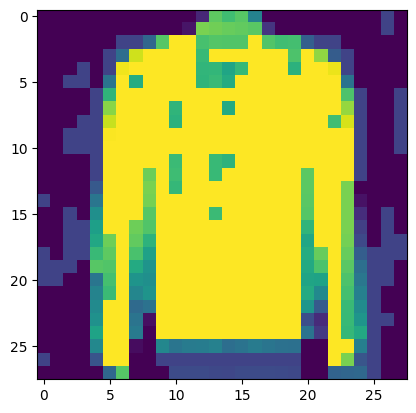


Here's what a 2-steps reconstructed sample looks like:



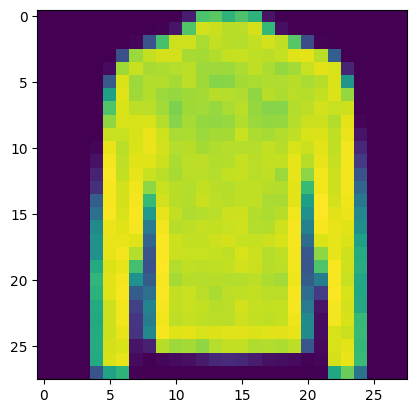


Epsilon: 0.2
Test Accuracy: 10.89%



In [ ]:
epsilon_value_for_reconstruction_test = 0.2

print(f"Testing DBN with 2 reconstruction steps against attack with epsilon = {epsilon_value_for_reconstruction_test}")
final_acc_dbn_reconstruct_2_steps = test_robustness_to_attack(
    dbn_with_readout,
    device,
    test_loader,
    epsilon=epsilon_value_for_reconstruction_test,
    num_steps=2
)

In [ ]:
epsilon_values = [0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30]

def test_epsilon_values_effect(model, n_steps):
  accuracies = list()

  for eps in epsilon_values:
      acc = test_robustness_to_attack(model, device, test_loader, eps, num_steps=n_steps, verbose=False)  # set verbose to False to avoid displaying too many images
      accuracies.append(acc)

  return accuracies

In [ ]:
%%capture
accuracies_ffnn = test_epsilon_values_effect(ffnn, n_steps=0)
accuracies_dbn_0 = test_epsilon_values_effect(dbn_with_readout, n_steps=0)
accuracies_dbn_1 = test_epsilon_values_effect(dbn_with_readout, n_steps=2)

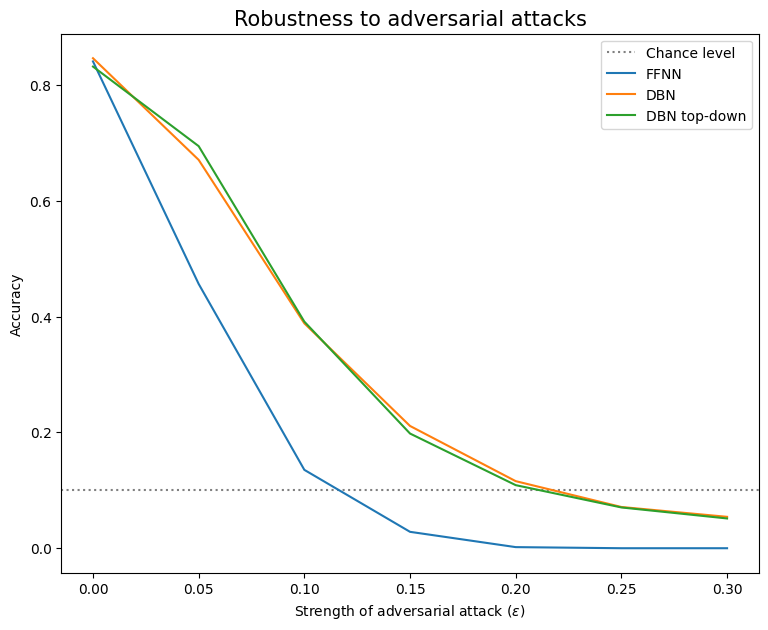

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7), sharey=True)

__ = ax.axhline(0.1, color='gray', linestyle=':')
__ = ax.plot(epsilon_values, accuracies_ffnn)
__ = ax.plot(epsilon_values, accuracies_dbn_0)
__ = ax.plot(epsilon_values, accuracies_dbn_1)
__ = ax.set_xlabel("Strength of adversarial attack ($\epsilon$)")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks", {'fontsize': 15})
__ = ax.legend(["Chance level", "FFNN", "DBN", "DBN top-down"])

### DBN with 35 top-down reconstruction steps

After some testing, is it possible to see how adding steps to the reconstruction process increases the accuracy (up to approximately 35 steps, with a 10% positive accuracy jump that occurred in a few tests). Adding even more steps starts to decrease the accuracy.

Testing DBN with 2 reconstruction steps against attack with epsilon = 0.2


  0%|          | 0/100 [00:00<?, ?it/s]


Here's the original sample:



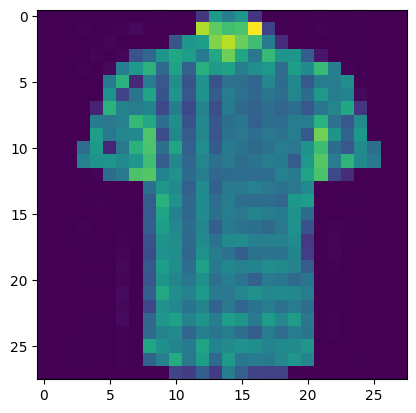


Here's a perturbed sample:



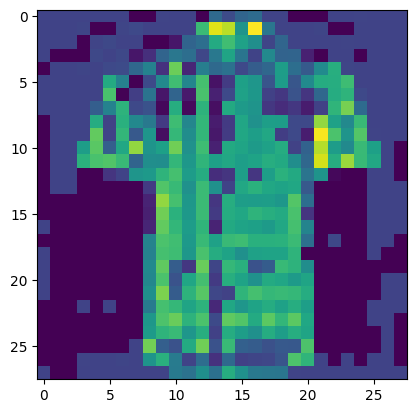


Here's what a 35-steps reconstructed sample looks like:



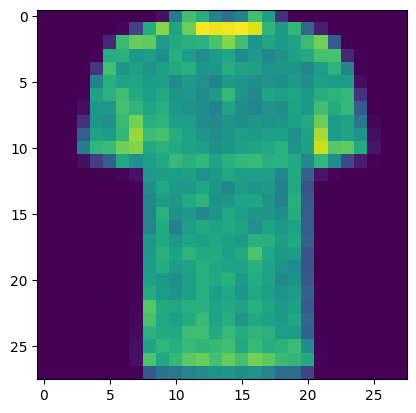


Epsilon: 0.2
Test Accuracy: 16.15%



In [ ]:
epsilon_value_for_reconstruction_test = 0.2

print(f"Testing DBN with 2 reconstruction steps against attack with epsilon = {epsilon_value_for_reconstruction_test}")
final_acc_dbn_reconstruct_2_steps = test_robustness_to_attack(
    dbn_with_readout,
    device,
    test_loader,
    epsilon=epsilon_value_for_reconstruction_test,
    num_steps=35
)

In [ ]:
epsilon_values = [0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30]

def test_epsilon_values_effect(model, n_steps):
  accuracies = list()

  for eps in epsilon_values:
      acc = test_robustness_to_attack(model, device, test_loader, eps, num_steps=n_steps, verbose=False)  # set verbose to False to avoid displaying too many images
      accuracies.append(acc)

  return accuracies

In [ ]:
%%capture
accuracies_ffnn = test_epsilon_values_effect(ffnn, n_steps=0)
accuracies_dbn_0 = test_epsilon_values_effect(dbn_with_readout, n_steps=0)
accuracies_dbn_1 = test_epsilon_values_effect(dbn_with_readout, n_steps=35)

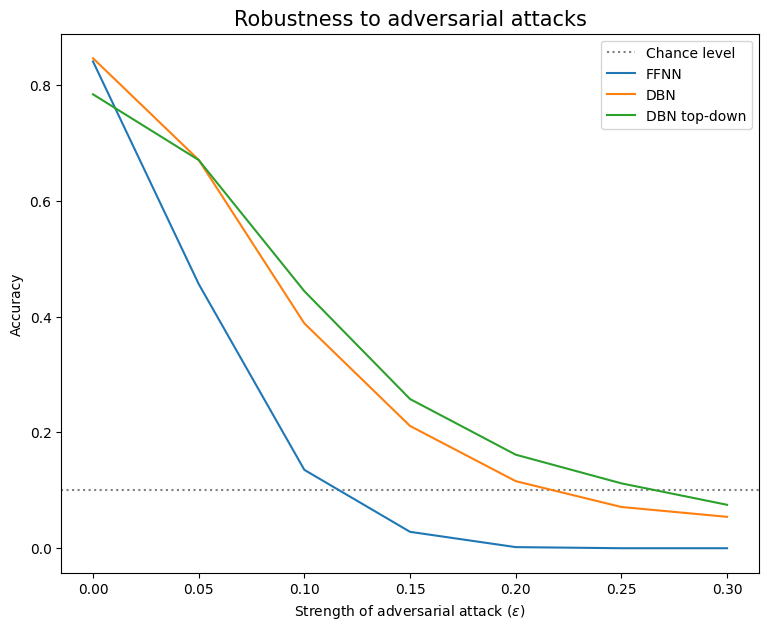

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7), sharey=True)

__ = ax.axhline(0.1, color='gray', linestyle=':')
__ = ax.plot(epsilon_values, accuracies_ffnn)
__ = ax.plot(epsilon_values, accuracies_dbn_0)
__ = ax.plot(epsilon_values, accuracies_dbn_1)
__ = ax.set_xlabel("Strength of adversarial attack ($\epsilon$)")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks", {'fontsize': 15})
__ = ax.legend(["Chance level", "FFNN", "DBN", "DBN top-down"])

# Conclusions

This project explored and compared two computational models for visual concept learning on the Fashion-MNIST dataset: a generative Deep Belief Network (DBN) and a discriminative Feedforward Neural Network (FFNN).

These models differ fundamentally in their learning paradigm: the DBN is trained in an unsupervised, layer-wise fashion to learn a hierarchical model of the input data's underlying probability distribution, while the FFNN is trained end-to-end in a supervised manner to learn decision boundaries that optimize for the specific task of classification.



*   **Feature representations**: The DBN successfully learned a meaningful hierarchy of features. The visualization of receptive fields showed a progression from simple edge detectors in the first hidden layer (H1) to more complex feature combinations in H2, and finally to clearer, "prototype-like" representations of whole object categories in the deepest layer (H3). This was further supported by hierarchical clustering, which consistently grouped semantically similar items (e.g., footwear, tops). However, an interesting discovery was that lower reconstruction error in the DBN (achieved with a larger model) did not necessarily translate to better performance on downstream tasks, probably due to overfitting.


*   **Error Patterns and Robustness**: Both models achieved similar baseline accuracies and, as revealed by the confusion matrices, tended to fail on the same visually ambiguous categories, such as 'Shirt' and 'T-shirt/top'. The DBN was significantly more robust to noise and targeted adversarial attacks (FGSM), and its generative nature allowed it to denoise perturbed inputs through a reconstruction defense.



